# Description

This notebook does the analyses regarding the spatial extent of ultra-slow fluctuations across the brain and generages Figure 7

In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import os
import hvplot.pandas
from utils.variables import Resources_Dir, DATA_DIR
from utils.basics    import get_available_runs, load_segments
import glob

import matplotlib.pyplot as plt
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map
from nilearn.image import load_img, index_img, iter_img
import panel as pn
from IPython.display import Markdown as md

%matplotlib inline

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# Notebook Configuration
REGION     = 'V4lt_grp'
REGRESSION = 'Reference'
remove_HRa_scans = False

***
# Load Lists of Scans

In [3]:
%%time
if remove_HRa_scans:
    scan_selection  = 'noHRa'
    scan_HR_info    = pd.read_csv(osp.join(Resources_Dir,'HR_scaninfo.csv'), index_col=0)
    scan_HR_info    = scan_HR_info[(scan_HR_info['HR_aliased']< 0.03) | (scan_HR_info['HR_aliased']> 0.07)]
    Manuscript_Runs = list(scan_HR_info.index)
    Awake_Runs      = list(scan_HR_info[scan_HR_info['Scan Type']=='Awake'].index)
    Drowsy_Runs     = list(scan_HR_info[scan_HR_info['Scan Type']=='Drowsy'].index)
else:
    scan_selection  = 'all'
    Manuscript_Runs = get_available_runs(when='final', type='all')
    Awake_Runs      = get_available_runs(when='final', type='awake')
    Drowsy_Runs     = get_available_runs(when='final', type='drowsy')

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 404 | Awake = 210 | Drowsy = 194
CPU times: user 2.86 ms, sys: 2.05 ms, total: 4.9 ms
Wall time: 4.54 ms


# Load Scan Segment Information: Eyes Open and Eyes Closed longer than 60 seconds

In [4]:
# Becuse manuscript run has already been restricted by noHRa (if needed), here we will only load the segments for the runs that are
# available given the current notebook configuration (e.g. all or noHRa)
Scan_Segments={'EC':load_segments(runs=Manuscript_Runs,kind='EC',min_dur=60),
               'EO':load_segments(runs=Manuscript_Runs,kind='EO',min_dur=60)}

++ INFO: segment_df has shape: (234, 8)
++ INFO: segment_df has shape: (755, 8)


> NOTE: To avoid issues with the last sample, we replace any Offset value equal to 890 with 889

In [5]:
Scan_Segments['EC']['Offset'].replace(890,889, inplace=True)
Scan_Segments['EO']['Offset'].replace(890,889, inplace=True)

***

# Generate Swarm Infrastructure: log directory, SWARM file

In [6]:
# Create Log Directory for swarm jobs
# ===================================
if not osp.exists('./N17_mPP_CorrMaps_Segments.logs'):
    print('++ INFO: Creating logging dir')
    os.mkdir('./N17_mPP_CorrMaps_Segments.logs')

In [7]:
### Create Swarm file for extracting representative power
# =====================================================
os.system('echo "#swarm -f ./N17_mPP_CorrMaps_Segments.SWARM.sh -g 16 -t 16 -b 30 --time 00:05:00 --partition quick,norm --module afni --logdir ./N17_mPP_CorrMaps_Segments.logs" > ./N17_mPP_CorrMaps_Segments.SWARM.sh')
# Add entries regarding periods of eye closure
for item in Manuscript_Runs:
    sbj,run = item.split('_',1) 
    aux = Scan_Segments['EC'][Scan_Segments['EC']['Run']==item]
    if aux.shape[0] > 0 :
        for i, row in aux.iterrows():
            vols = '[{onset}..{offset}]'.format(onset=int(row['Onset']),offset=int(row['Offset']))
            segment_uuid = row['Segment_UUID']
            os.system('echo "export SBJ={sbj} REGION={REGION} REGRESSION={REGRESSION} RUN={run} VOLS={vols} TYPE=EC UUID={segment_uuid}; sh ./N17_mPP_CorrMaps_Segments.sh" >> ./N17_mPP_CorrMaps_Segments.SWARM.sh'.format(sbj=sbj, run=run, vols=vols, segment_uuid=segment_uuid, REGION=REGION, REGRESSION=REGRESSION))

# Add entries regarding periods of eye opening
for item in Manuscript_Runs:
    sbj,run = item.split('_',1) 
    aux = Scan_Segments['EO'][Scan_Segments['EO']['Run']==item]
    if aux.shape[0] > 0 :
        for i, row in aux.iterrows():
            vols = '[{onset}..{offset}]'.format(onset=int(row['Onset']),offset=int(row['Offset']))
            segment_uuid = row['Segment_UUID']
            os.system('echo "export SBJ={sbj} REGION={REGION} REGRESSION={REGRESSION} RUN={run} VOLS={vols} TYPE=EO UUID={segment_uuid}; sh ./N17_mPP_CorrMaps_Segments.sh" >> ./N17_mPP_CorrMaps_Segments.SWARM.sh'.format(sbj=sbj, run=run, vols=vols, segment_uuid=segment_uuid, REGION=REGION, REGRESSION=REGRESSION))

***

# Run Swarm Jobs

Becuase each scan segment has a unique identifier that gets generated every time you run the previous cell, it is very important to make sure that every time that you run this code you start with clean directories. 

Run the code below on a terminal on a biowulf node to make sure that you have clean directories before you run the job

> **NOTE**: I recommend you only run the swarm jobs when ```remove_HRa_scans = False``` becuase that way you will have all ouputs created for all scans. Next, when you want to compare results without including scans with overlapped HRa, you can just skip this part of the code and go directly to loading results

> ## Delete previously created files (random IDs)
```bash
cd /data/SFIMJGC_HCP7T/HCP7T
if [ -f N17_outputs_to_delete.txt ]; then
   rm N17_outputs_to_delete.txt
fi

find ./ -name "rm.??.rfMRI_REST?_??_mPP.????????-????-????-????-????????????.1D"         > N17_outputs_to_delete.txt
find ./ -name "rm.??.rfMRI_REST?_??_mPP.????????-????-????-????-????????????.cmap.nii"  >> N17_outputs_to_delete.txt
find ./ -name "rm.??.rfMRI_REST?_??_mPP.????????-????-????-????-????????????.Zcmap.nii" >> N17_outputs_to_delete.txt

    
for SUFFIX in mPP mPP.SC01_errts mPP.SC02_errts mPP.SC06_errts 
do
    find ./ -name "rm.??.rfMRI_REST?_??_${SUFFIX}.????????-????-????-????-????????????.cmap.Schaefer2018_7Nws_200.1D" >> N17_outputs_to_delete.txt
    find ./ -name "rm.??.rfMRI_REST?_??_${SUFFIX}.????????-????-????-????-????????????.cmap.Schaefer2018_17Nws_200.1D" >> N17_outputs_to_delete.txt
    find ./ -name "rm.??.rfMRI_REST?_??_${SUFFIX}.????????-????-????-????-????????????.cmap.nii*" >> N17_outputs_to_delete.txt
    find ./ -name "rm.??.rfMRI_REST?_??_${SUFFIX}.????????-????-????-????-????????????.Zcmap.nii*" >> N17_outputs_to_delete.txt
done

sed -i -e 's/^/rm /' N17_outputs_to_delete.txt
sh ./N17_outputs_to_delete.txt
rm ./N17_outputs_to_delete.txt
```

> ## Run the jobs
```bash
cd /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/
rm ./N17_mPP_CorrMaps_Segments.logs/*
swarm -f ./N17_mPP_CorrMaps_Segments.SWARM.sh -g 16 -t 16 -b 30 --time 00:05:00 --partition quick,norm --module afni --logdir ./N17_mPP_CorrMaps_Segments.logs
```

***
# Check all output files were produced via the batch jobs

In [8]:
ALL_DIR  = '/data/SFIMJGC_HCP7T/HCP7T/ALL/'

In [9]:
num_missing_files = 0
for eye_condition in ['EC','EO']:
    for r, row in Scan_Segments[eye_condition].iterrows():
        sbj,run = row['Run'].split('_',1)
        cmap_file = osp.join(DATA_DIR,sbj,run,'rm.{ec}.{run}_{REGRESSION}.{uuid}.cmap.nii'.format(run=run,uuid=row['Segment_UUID'], ec=eye_condition, REGRESSION=REGRESSION))
        if not osp.exists(cmap_file):
            print('++ WARNING: Missing file [%s]' % cmap_file)
            num_missing_files += 1
print('++ INFO: Total number of missing files = %d' % num_missing_files)

++ INFO: Total number of missing files = 0


In [10]:
for suffix in [REGRESSION]:
    for group in ['EC','EO']:   
        files = glob.glob(osp.join(DATA_DIR,'??????','rfMRI_REST?_??','rm.{group}.rfMRI_REST?_??_{suffix}.????????-????-????-????-????????????.Zcmap.nii'.format(group=group,suffix=suffix)))
        print('++ INFO: [%s,%s] = %d' % (group,suffix,len(files)))
    print('')

++ INFO: [EC,Reference] = 234
++ INFO: [EO,Reference] = 755



***
# Create Group-Level FB mask

Open a terminal in a biowulf node and run the following commands

```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL/
3dMean     -overwrite -prefix ROI.ALL.FB.mPP.avg.nii.gz ../??????/ROI.FB.mPP.nii.gz
3dcalc     -overwrite -a      ROI.ALL.FB.mPP.avg.nii.gz -expr 'step(a-0.75)' -prefix ROI.ALL.FB.mPP.mask.nii.gz
```

***
# Create Correlation Maps with FV Signal for EO and EC segments & Check for Statistical Differences

Becuase of the long list of files, it looks like I cannot make a system call to execute the commands generated in the cell above. 

As an alternative, I now write them to a file names ./N17_Commands.sh that needs to be executed directly on the shell. You can use the following code to do that:

> According to the AFNI people, the NIFTI format should only use the 4th dimension for time. When dealing with non-timeseries, the extra dimensions should be in 5th dim. This is not followed by nilearn, which causes the data not to be loaded properly. See https://afni.nimh.nih.gov/afni/community/board/read.php?1,89081,89081#msg-89081. To solve this issue, we run the 3dTcat command to transform the 3dbucket into a time-series (e.g. only 4D), so that we can load it and present it with nilearn here.

In [11]:
%%time
mask_path = osp.join(ALL_DIR,'ROI.ALL.FB.mPP.mask.nii.gz')
command_file = open('./N17_Commands.{ss}.sh'.format(ss=scan_selection),'w+')
# Create file with difference between both maps
# =============================================
for suffix in  [REGRESSION]:
    print(suffix)
    EC_files = glob.glob(osp.join(DATA_DIR,'??????','rfMRI_REST?_??','rm.{group}.rfMRI_REST?_??_{suffix}.????????-????-????-????-????????????.Zcmap.nii'.format(group='EC',suffix=suffix)))
    EO_files = glob.glob(osp.join(DATA_DIR,'??????','rfMRI_REST?_??','rm.{group}.rfMRI_REST?_??_{suffix}.????????-????-????-????-????????????.Zcmap.nii'.format(group='EO',suffix=suffix)))
    out_file = 'ECvsEO_{suffix}.{REGION}.corrmap.TTEST.{ss}.nii.gz'.format(suffix=suffix, REGION=REGION, ss=scan_selection)
    out_path = osp.join(ALL_DIR,out_file)
    out_file2 = 'ECvsEO_{suffix}.{REGION}.corrmap.TTEST.{ss}.nilearn.nii.gz'.format(suffix=suffix, REGION=REGION, ss=scan_selection)
    out_path2 = osp.join(ALL_DIR,out_file2)
    command_file.write('# ++ INFO: Generating output for [%s] --> %s\n' % (suffix,out_path))
    command  = 'module load afni\ncd {all_dir}\n3dttest++ -overwrite -mask {mpath} -labelA EC -labelB EO -overwrite -setA {ec_files} -setB {eo_files} -prefix {opath} -unpooled\n'.format(mpath    = mask_path,
                                                                                                                                                                   all_dir = ALL_DIR,
                                                                                                                                                                   ec_files = ' '.join(EC_files),
                                                                                                                                                                   eo_files =' '.join(EO_files),
                                                                                                                                                                   opath    = out_file)
    command_file.write(command)
    command_file.write('# + Running 3dttest+ command....\n')
    command_file.write('# + ------------------------------------------------------------------------------------------------------------------------\n')
    # Covert R subbricks in output from 3dttest++ back to R values (inputs where Fisher transforms)
    # =============================================================================================
    command_file.write('# + Running 3dcalc + 3dbucket command....\n')
    command  = '3dcalc -overwrite -a {opath}[0] -m {mpath} -expr "m*tanh(a)" -prefix sb0_toR.nii\n'.format(mpath = mask_path, opath = out_file)
    command_file.write(command)
    command  = '3dcalc -overwrite -a {opath}[2] -m {mpath} -expr "m*tanh(a)" -prefix sb2_toR.nii\n'.format(mpath = mask_path, opath = out_file)
    command_file.write(command)
    command  = '3dcalc -overwrite -a {opath}[4] -m {mpath} -expr "m*tanh(a)" -prefix sb4_toR.nii\n'.format(mpath = mask_path, opath = out_file)
    command_file.write(command)
    command  = '3dbucket -overwrite -prefix {opath} sb0_toR.nii {opath}[1] sb2_toR.nii {opath}[3] sb4_toR.nii {opath}[5]\n'.format(opath = out_file)
    command_file.write(command)
    command  = '3dTcat -overwrite -prefix {opath2} {opath}\n'.format(opath = out_file, opath2=out_file2)
    command_file.write(command)
command_file.write('# [COMPLETED for %s]\n' % suffix)
command_file.write('# + ---------------------------------  END OF THIS CELL ---------------------------------------------------------------------------------------\n')
command_file.close()

Reference
CPU times: user 226 ms, sys: 142 ms, total: 368 ms
Wall time: 432 ms


In [12]:
text = '''
To run the code generated in the cell above, open a terminal in a biowulf node and run the following code:

```bash
cd /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/
module load afni
sh ./N17_Commands.{ss}.sh
```
'''.format(ss=scan_selection)
md("%s"%(text))


To run the code generated in the cell above, open a terminal in a biowulf node and run the following code:

```bash
cd /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/
module load afni
sh ./N17_Commands.all.sh
```


***

# Create Average T1 (to be used as underlay)

Please run the following code on a terminal on a biowulf node:

```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL
3dMean -overwrite -prefix T1w_restore_brain.MEAN.nii.gz ../??????/T1w_restore_brain.nii.gz
3dAutobox -overwrite -prefix T1w_restore_brain.MEAN.abox.nii.gz T1w_restore_brain.MEAN.nii.gz
```

***
# Create Correlation Maps per Segment Type and regions with significant differences

The labels of the different subbricks are:

| Index | Label      | Description                                                                      |
|-------|------------|----------------------------------------------------------------------------------|
| 0     | EC-EO_mean | Mean difference (R-values) between eyes open and eyes closed condition           |
| 1     | EC-EO_Zscr | Z-score test for the difference between the two conditions (Index = 0)           |
| 2     | EC_mean    | Mean correlation (R-values) to the signal in the 4th ventricle for periods of EC |
| 3     | EC_Zscr    | Z-score test for mean correlation in EC being different from zero                |
| 4     | EO_mean    | Mean correlation (R-values) to the signal in the 4th ventricle for periods of EO |
| 5     | EO_Zscr    | Z-score test for mean correlation in EO being different from zero                |

In [13]:
text = '''Final version of the maps depicted in Figure 7 were generated in AFNI becuase AFNI provides more freedom on how to select threshold for negative values, and has edge and alpha functionalities. To get the actual final images, you can run the following AFNI drive me command:


```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL

module load afni

afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \\
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_{REGRESSION}.{REGION}.corrmap.TTEST.{ss}.nii.gz" -com "SET_SUBBRICKS A 0 0 1" \\
     -com "SET_THRESHNEW A 1e-7 *p" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" \\
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Axial.{ss}.png" \\
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Sagittal.{ss}.png" -com "QUITT"
     
afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \\
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_{REGRESSION}.{REGION}.corrmap.TTEST.{ss}.nii.gz" -com "SET_SUBBRICKS A 0 2 2" \\
     -com "SET_THRESHNEW A 0.2 *" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" -com "SET_FUNC_ALPHA A.On" \\
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Axial.{ss}.png" \\
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Sagittal.{ss}.png" -com "QUITT"
     
afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \\
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_{REGRESSION}.{REGION}.corrmap.TTEST.{ss}.nii.gz" -com "SET_SUBBRICKS A 0 4 4" \\
     -com "SET_THRESHNEW A 0.2 *" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" -com "SET_FUNC_ALPHA A.On" \\
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Axial.{ss}.png" \\
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Sagittal.{ss}.png" -com "QUITT"
```'''.format(REGION=REGION, REGRESSION=REGRESSION, ss=scan_selection)
md("%s"%(text))

Final version of the maps depicted in Figure 7 were generated in AFNI becuase AFNI provides more freedom on how to select threshold for negative values, and has edge and alpha functionalities. To get the actual final images, you can run the following AFNI drive me command:


```bash
cd /data/SFIMJGC_HCP7T/HCP7T/ALL

module load afni

afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_Reference.V4lt_grp.corrmap.TTEST.all.nii.gz" -com "SET_SUBBRICKS A 0 0 1" \
     -com "SET_THRESHNEW A 1e-7 *p" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" \
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Axial.all.png" \
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Sagittal.all.png" -com "QUITT"
     
afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_Reference.V4lt_grp.corrmap.TTEST.all.nii.gz" -com "SET_SUBBRICKS A 0 2 2" \
     -com "SET_THRESHNEW A 0.2 *" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" -com "SET_FUNC_ALPHA A.On" \
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Axial.all.png" \
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Sagittal.all.png" -com "QUITT"
     
afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 -com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \
     -com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" -com "SWITCH_OVERLAY ECvsEO_Reference.V4lt_grp.corrmap.TTEST.all.nii.gz" -com "SET_SUBBRICKS A 0 4 4" \
     -com "SET_THRESHNEW A 0.2 *" -com "SET_PBAR_ALL A.-99 0.4 Reds_and_Blues_Inv" -com "SET_XHAIRS A.OFF" -com "SET_FUNC_BOXED A.On" -com "SET_FUNC_ALPHA A.On" \
     -com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Axial.all.png" \
     -com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Sagittal.all.png" -com "QUITT"
```

***

# Create Histogram of correlation values in the brain

In [14]:
ttest_path      = osp.join(ALL_DIR,'ECvsEO_{REGRESSION}.{REGION}.corrmap.TTEST.{ss}.nilearn.nii.gz'.format(REGION=REGION,REGRESSION=REGRESSION, ss=scan_selection))
ttest_img       = load_img(ttest_path)

In [15]:
mask_path       = osp.join(ALL_DIR,'ROI.ALL.FB.mPP.mask.nii.gz')
mask_img        = load_img(mask_path)

In [16]:
fb_correlations_ec = pd.DataFrame(apply_mask(index_img(ttest_img,2),mask_img))
fb_correlations_eo = pd.DataFrame(apply_mask(index_img(ttest_img,4),mask_img))

In [17]:
fig07_PanelC = fb_correlations_ec.hvplot.hist(bins=100, alpha=0.5, normed=True, width=400, height=500,fontsize={'labels':14, 'ticks':14, 'title':16}) * \
fb_correlations_ec.hvplot.kde(alpha=0.5, label='Eyes Closed') * \
fb_correlations_eo.hvplot.hist(bins=100, alpha=0.5, normed=True) * \
fb_correlations_eo.hvplot.kde(alpha=0.5, xlim=(-0.6,.6),
                              c='orange',
                              label='Eyes Open',
                              xlabel='Zero-Lag Correlation [4th Vent., Brain]',
                              ylabel='Histogram/Density',
                              title='Distribution of R values').opts(toolbar=None)

***
# Combine all Panels to Generate Figure 7

In [18]:
Fig07_BrainMaps = pn.Row(pn.Column(pn.Row(pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Axial.{ss}.png'.format(ss=scan_selection), height=200),
                 pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EC_Sagittal.{ss}.png'.format(ss=scan_selection), height=200)),
          pn.Row(pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Axial.{ss}.png'.format(ss=scan_selection), height=200),
                 pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_EO_Sagittal.{ss}.png'.format(ss=scan_selection), height=200)),
          pn.Row(pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Axial.{ss}.png'.format(ss=scan_selection), height=200),
                 pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/images/Fig07_ECvsEO_Sagittal.{ss}.png'.format(ss=scan_selection), height=200))),
          fig07_PanelC)
Fig07_BrainMaps.save('./figures/Fig07_BrainMaps.{ss}.png'.format(ss=scan_selection))

Row
    [0] Column
        [0] Row
            [0] PNG(str, height=200)
            [1] PNG(str, height=200)
        [1] Row
            [0] PNG(str, height=200)
            [1] PNG(str, height=200)
        [2] Row
            [0] PNG(str, height=200)
            [1] PNG(str, height=200)
    [1] HoloViews(Overlay)
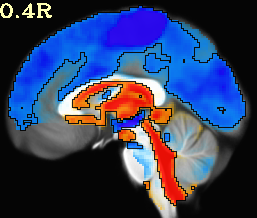
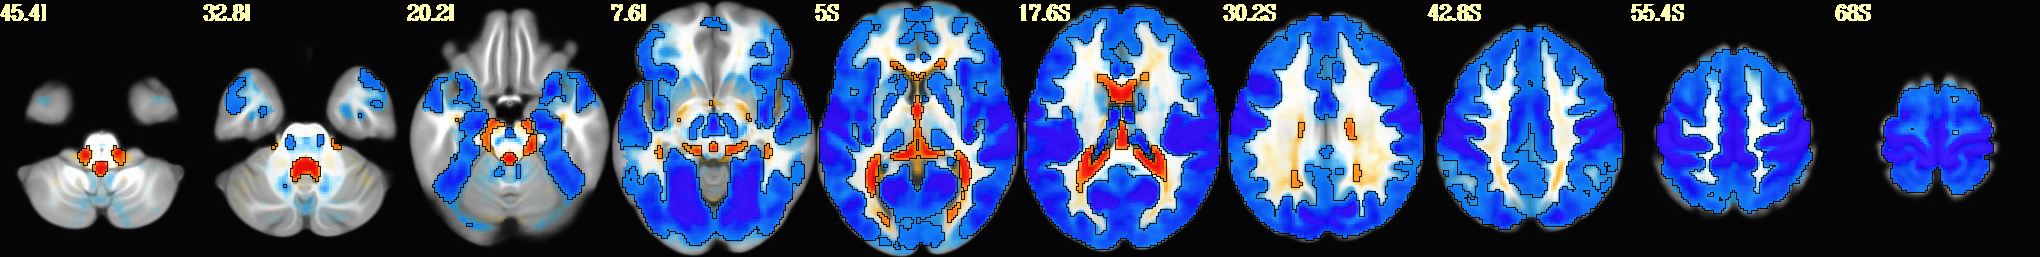
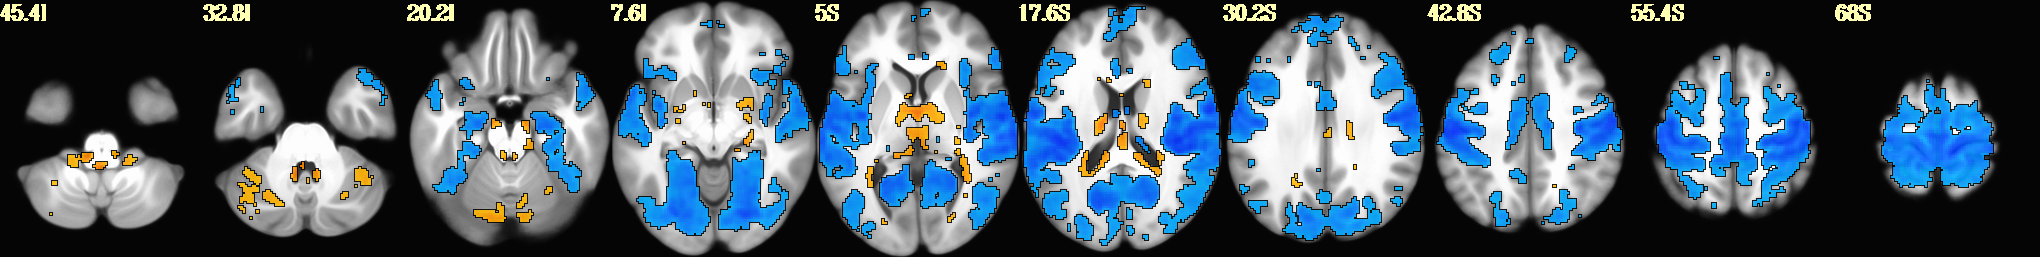
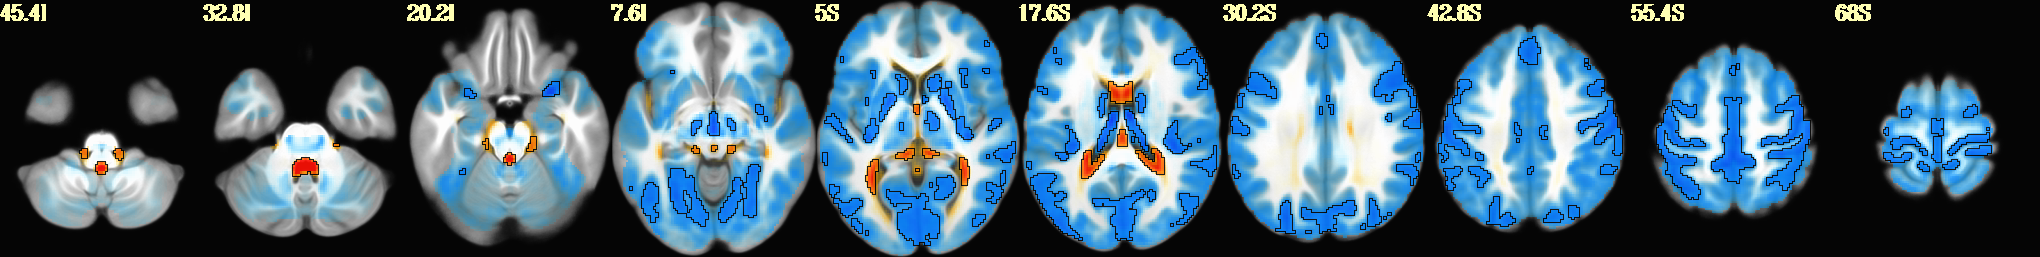
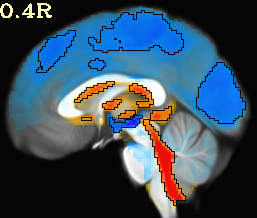
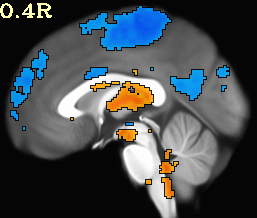

In [19]:
Fig07_BrainMaps

***
# Brain Maps plotted with NiLearn (not used in Manuscript)

In [20]:
t1_path         = osp.join(ALL_DIR,'T1w_restore_brain.MEAN.abox.nii.gz')
t1_bg           = load_img(t1_path)

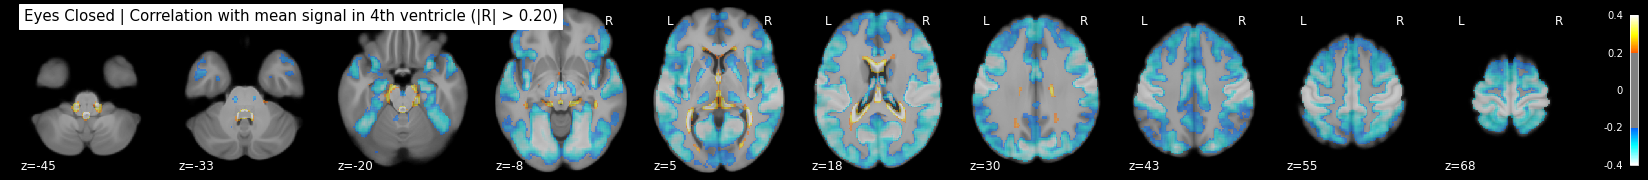

In [21]:
fig07_PanelA = plot_stat_map(index_img(ttest_img,2),t1_bg,display_mode='z',alpha=0.5, vmax=0.4, cut_coords=[-45,-33,-20,-8,5,18,30,43,55,68],threshold = 0.20, title='Eyes Closed | Correlation with mean signal in 4th ventricle (|R| > 0.20)')

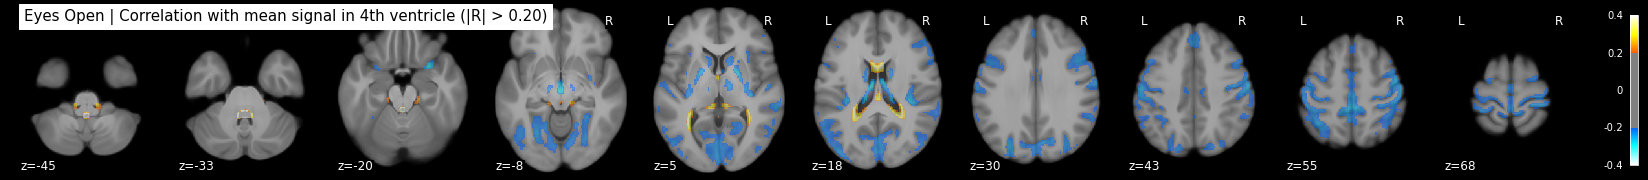

In [22]:
fig07_PanelB = plot_stat_map(index_img(ttest_img,4),t1_bg,display_mode='z',alpha=0.5, vmax=0.4, cut_coords=[-45,-33,-20,-8,5,18,30,43,55,68],threshold = 0.20, title='Eyes Open | Correlation with mean signal in 4th ventricle (|R| > 0.20)')